In [70]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import mne
import warnings
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import random
import pandas as pd
import seaborn as sns
from collections import Counter

# Suppress warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)
mne.set_log_level("WARNING")

# Set random seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [71]:
class EEG_Model(nn.Module):
    def __init__(self):
        super(EEG_Model, self).__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3, stride=1)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(2)
        self.lstm1 = nn.LSTM(input_size=128, hidden_size=128, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=128, hidden_size=64, batch_first=True)
        self.fc1 = nn.Linear(64, 128)
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 5)
    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.transpose(1, 2)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

In [72]:
# Sleep stage to class mapping
LABEL_MAP = {
    "Sleep stage W": 0,    # Wake
    "Sleep stage 1": 1,    # N1 (Light sleep)
    "Sleep stage 2": 2,    # N2 (Light sleep)
    "Sleep stage 3": 3,    # N3 (Deep sleep)
    "Sleep stage 4": 3,    # N4 -> N3 (combined deep sleep)
    "Sleep stage R": 4     # REM sleep
}

In [73]:
def preprocess_data(data_dir, epoch_duration=30, sfreq=100):
    """
    Preprocesses EEG data from the Sleep-EDF dataset.
    
    Args:
        data_dir (str): Path to your Sleep-EDF dataset folder
        epoch_duration (int): Duration of each epoch in seconds (default: 30)
        sfreq (int): Target sampling frequency (default: 100 Hz)
    
    Returns:
        tuple: (X, y) where X is EEG data and y is sleep stage labels
    """
    # Create arrays for data
    X_list = []
    y_list = []

    # Process all PSG.edf files in the directory
    for file in os.listdir(data_dir):
        if not file.endswith("PSG.edf"):
            continue  

        psg_path = os.path.join(data_dir, file)

        # Get base ID (e.g., 'SC4001')
        base_id = file[:6]

        # Find corresponding hypnogram file
        hypnogram_candidates = [f for f in os.listdir(data_dir)
                                if f.startswith(base_id) and "Hypnogram" in f]

        if not hypnogram_candidates:
            print(f"Skipping {file}: missing hypnogram")
            continue

        hypnogram_path = os.path.join(data_dir, hypnogram_candidates[0])

        try:
            # Load EEG data and sleep stage annotations
            raw = mne.io.read_raw_edf(psg_path, preload=True)
            annotations = mne.read_annotations(hypnogram_path)
            raw.set_annotations(annotations)

            # Select specific EEG channels and apply bandpass filter
            raw.pick_channels(['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'EMG submental'])
            raw.filter(0.5, 30)  # 0.5-30 Hz bandpass filter

            # Extract events from annotations
            available_event_ids = {
                k: v for k, v in LABEL_MAP.items()
                if k in [ann['description'] for ann in annotations]
            }
            events, _ = mne.events_from_annotations(raw, event_id=available_event_ids, verbose=False)

            # Skip if no valid events found
            if events.shape[0] == 0:
                print(f"Skipping {file}: no valid events")
                continue

            # Create 30-second epochs
            epochs = mne.Epochs(
                raw, events=events, event_id=available_event_ids,
                tmin=0, tmax=epoch_duration, baseline=None,
                preload=True, verbose=False
            )

            # Convert to numpy array
            X = epochs.get_data()

            # Process labels
            stage_labels = [LABEL_MAP.get(ann['description'], -1) for ann in annotations]
            valid_idx = [i for i, stage in enumerate(stage_labels) if stage != -1]

            # Ensure matching lengths
            min_len = min(len(X), len(valid_idx))
            X = X[:min_len]
            y = [stage_labels[i] for i in valid_idx[:min_len]]

            # Add to collections
            X_list.append(X)
            y_list.append(y)

        except Exception as e:
            continue

    # Combine all subjects
    X = np.vstack(X_list)
    y = np.hstack(y_list)
    
    # Normalize
    X = (X - X.mean()) / X.std()

    print(f"Total processed: {len(X)} epochs from {len(X_list)} subjects")

    # Create data directory if it doesn't exist
    os.makedirs("data", exist_ok=True)
    
    # Save preprocessed data for future use
    np.save("data/X.npy", X)
    np.save("data/y.npy", y)

    return X, y

In [74]:
def create_data_loaders(X, y, batch_size=64):
    """
    Create DataLoader objects for training, validation, and test datasets.
    
    Args:
        X (np.ndarray): Input EEG data (epochs)
        y (np.ndarray): Sleep stage labels
        batch_size (int): Batch size for training
        
    Returns:
        tuple: (train_loader, val_loader, test_loader, user_loader)
    """
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.long)
    dataset = TensorDataset(X_tensor, y_tensor)
    generator = torch.Generator().manual_seed(41)
    
    # Define split sizes
    train_size = int(0.7 * len(dataset))   # 70% training
    val_size = int(0.15 * len(dataset))    # 15% validation
    test_size = int(0.15 * len(dataset))   # 15% testing
    user_size = len(dataset) - train_size - val_size - test_size  # Remainder

    # Split the dataset
    train_dataset, val_dataset, test_dataset, user_dataset = random_split(
        dataset, [train_size, val_size, test_size, user_size], generator=generator
    )
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    user_loader = DataLoader(user_dataset, batch_size=batch_size, shuffle=False)

    print(f"Data split - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

    return train_loader, val_loader, test_loader, user_loader

In [75]:
def evaluate(model, dataloader, criterion, device):
    """
    Evaluate model performance on a dataset.
    
    Returns:
        tuple: (error_rate, avg_loss, f1_macro, classification_report, confusion_matrix)
    """
    model.eval()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for eeg_data, labels in dataloader:
            eeg_data, labels = eeg_data.to(device), labels.to(device)
            outputs = model(eeg_data)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    error = 1 - (total_correct / total_samples)
    avg_loss = total_loss / len(dataloader)

    f1_macro = f1_score(all_labels, all_preds, average='macro')
    class_report = classification_report(all_labels, all_preds, digits=4, output_dict=True, zero_division=0)
    conf_mat = confusion_matrix(all_labels, all_preds)

    return error, avg_loss, f1_macro, class_report, conf_mat

In [76]:
def plot_curve(path):
    """ 
    Plots the training and validation curves for accuracy and loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt(f"{path}_train_err.csv")
    train_loss = np.loadtxt(f"{path}_train_loss.csv")
    val_err = np.loadtxt(f"{path}_val_err.csv")
    val_loss = np.loadtxt(f"{path}_val_loss.csv")

    train_acc = 1 - train_err
    val_acc = 1 - val_err
    n = len(train_acc)

    # Accuracy plot
    plt.figure()
    plt.title("Accuracy Over Epochs")
    plt.plot(range(1, n+1), train_acc, label="Train Accuracy")
    plt.plot(range(1, n+1), val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()
    plt.show()

    # Loss plot
    plt.figure()
    plt.title("Loss Over Epochs")
    plt.plot(range(1, n+1), train_loss, label="Train Loss")
    plt.plot(range(1, n+1), val_loss, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

In [77]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """
    Generate a unique model name based on hyperparameters.
    """
    return f"{name}_bs{batch_size}_lr{learning_rate}_epoch{epoch}"

def log_run(file_path, params, metrics):
    """
    Log training run parameters and results.
    """
    with open(file_path, "a") as f:
        f.write("=== New Model Run ===\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
        for key, value in metrics.items():
            f.write(f"{key}: {value}\n")
        f.write("\n")

In [78]:
def train_CNN(model, train_loader, val_loader, test_loader, weight, batch_size=64, learning_rate=0.001, num_epochs=30, plot_path=None):
    """
    Train the CNN-LSTM model for sleep stage classification.
    
    Args:
        model: The EEG_Model instance
        train_loader: Training data loader
        val_loader: Validation data loader
        test_loader: Test data loader
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer
        num_epochs: Number of training epochs
        plot_path: Path to save training metrics
    
    Returns:
        tuple: Training and validation losses and errors
    """
    # Create plots directory
    if plot_path:
        os.makedirs(os.path.dirname(plot_path), exist_ok=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    print(f"Using device: {torch.cuda.get_device_name(torch.cuda.current_device()) if torch.cuda.is_available() else 'CPU'}")

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=weight)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # Arrays to track metrics
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        correct_train = 0
        total_train = 0
        total_train_loss = 0

        for batch_idx, (eeg_data, labels) in enumerate(train_loader):
            eeg_data, labels = eeg_data.to(device), labels.to(device)

            # Forward and backward pass
            optimizer.zero_grad()
            outputs = model(eeg_data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate metrics
            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        # Save training metrics
        train_loss[epoch] = total_train_loss / len(train_loader)
        train_err[epoch] = 1 - (correct_train / total_train)

        # Evaluate on validation set
        val_err[epoch], val_loss[epoch], _, _, _ = evaluate(model, val_loader, criterion, device)

        # Print progress
        print(f"Epoch {epoch+1:2d}/{num_epochs}: "
              f"Train Loss: {train_loss[epoch]:.4f}, Train Acc: {1-train_err[epoch]:.4f} | "
              f"Val Loss: {val_loss[epoch]:.4f}, Val Acc: {1-val_err[epoch]:.4f}")

    # Save training metrics
    if plot_path:
        np.savetxt(f"{plot_path}_train_err.csv", train_err)
        np.savetxt(f"{plot_path}_train_loss.csv", train_loss)
        np.savetxt(f"{plot_path}_val_err.csv", val_err)
        np.savetxt(f"{plot_path}_val_loss.csv", val_loss)

    # Log the run
    params = {
        "Model": "EEG_Model",
        "Epochs": num_epochs,
        "Batch Size": batch_size,
        "Learning Rate": learning_rate,
    }

    metrics = {
        "Final Train Accuracy": round(1 - train_err[-1], 4),
        "Final Val Accuracy": round(1 - val_err[-1], 4),
        "Final Train Loss": round(train_loss[-1], 4),
        "Final Val Loss": round(val_loss[-1], 4),
    }

    log_run("results_log.txt", params, metrics)

    return train_loss, train_err, val_loss, val_err

In [79]:
if os.path.exists("data/X.npy") and os.path.exists("data/y.npy"):
    X = np.load("data/X.npy")
    y = np.load("data/y.npy")
else:
    X, y = preprocess_data("C:/Users/namgy/Downloads/sleep-edf-database-expanded-1.0.0/sleep-edf-database-expanded-1.0.0/sleep-cassette")
    np.save("data/X.npy", X)
    np.save("data/y.npy", y)

In [80]:
if 'X' in locals() and 'y' in locals():
    train_loader, val_loader, test_loader, user_loader = create_data_loaders(
        X, y, batch_size=32
    )

Data split - Train: 15492, Val: 3319, Test: 3319


In [81]:
# Count class labels from train_loader
label_counts = Counter()

for _, labels in train_loader:
    label_counts.update(labels.numpy().tolist())

total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Compute weights (inverse frequency)
weights = [total_samples / label_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(weights, dtype=torch.float32)

In [83]:
# Accumulate all labels from the training set
all_train_labels = []

for _, labels in train_loader:
    all_train_labels.extend(labels.numpy())

# Count labels
counts = Counter(all_train_labels)

# Optional: map label indices to names
class_names = ['Wake', 'N1', 'N2', 'N3', 'REM']

for i in range(len(class_names)):
    print(f"{class_names[i]}: {counts[i]} samples")


Wake: 2575 samples
N1: 4112 samples
N2: 4538 samples
N3: 3184 samples
REM: 1083 samples


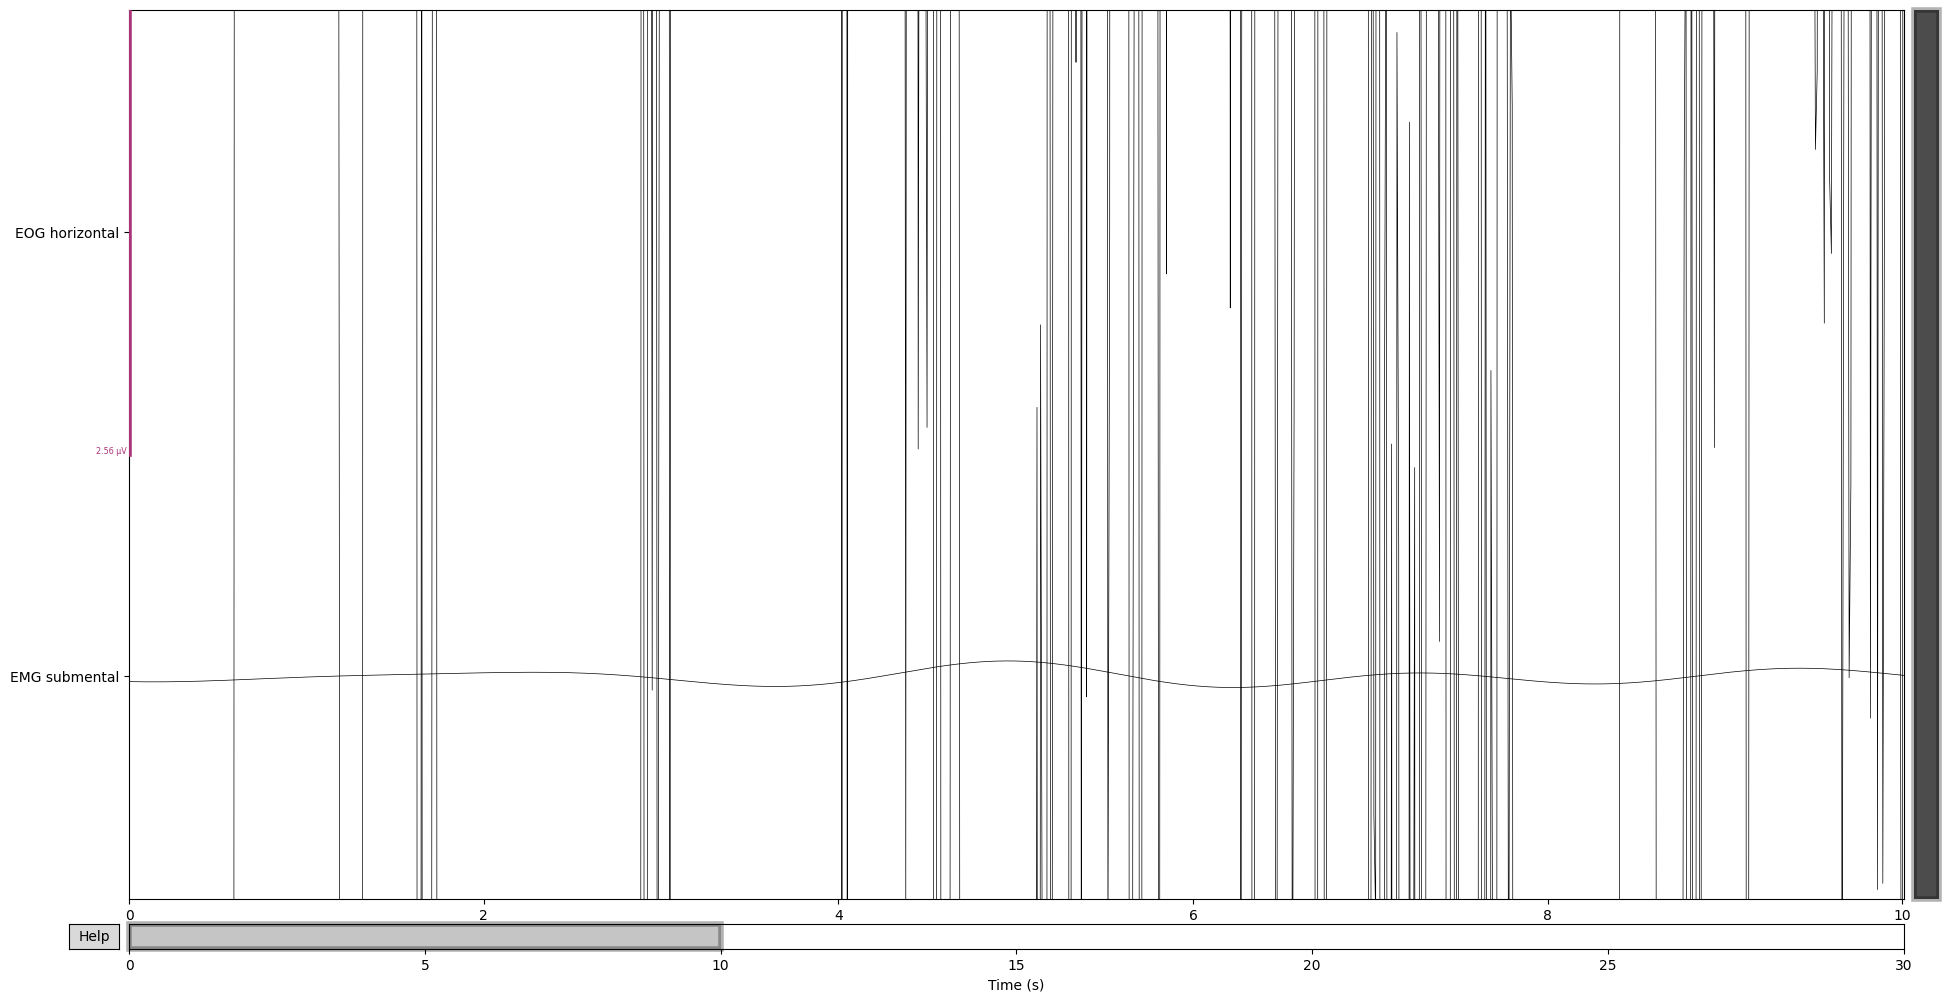

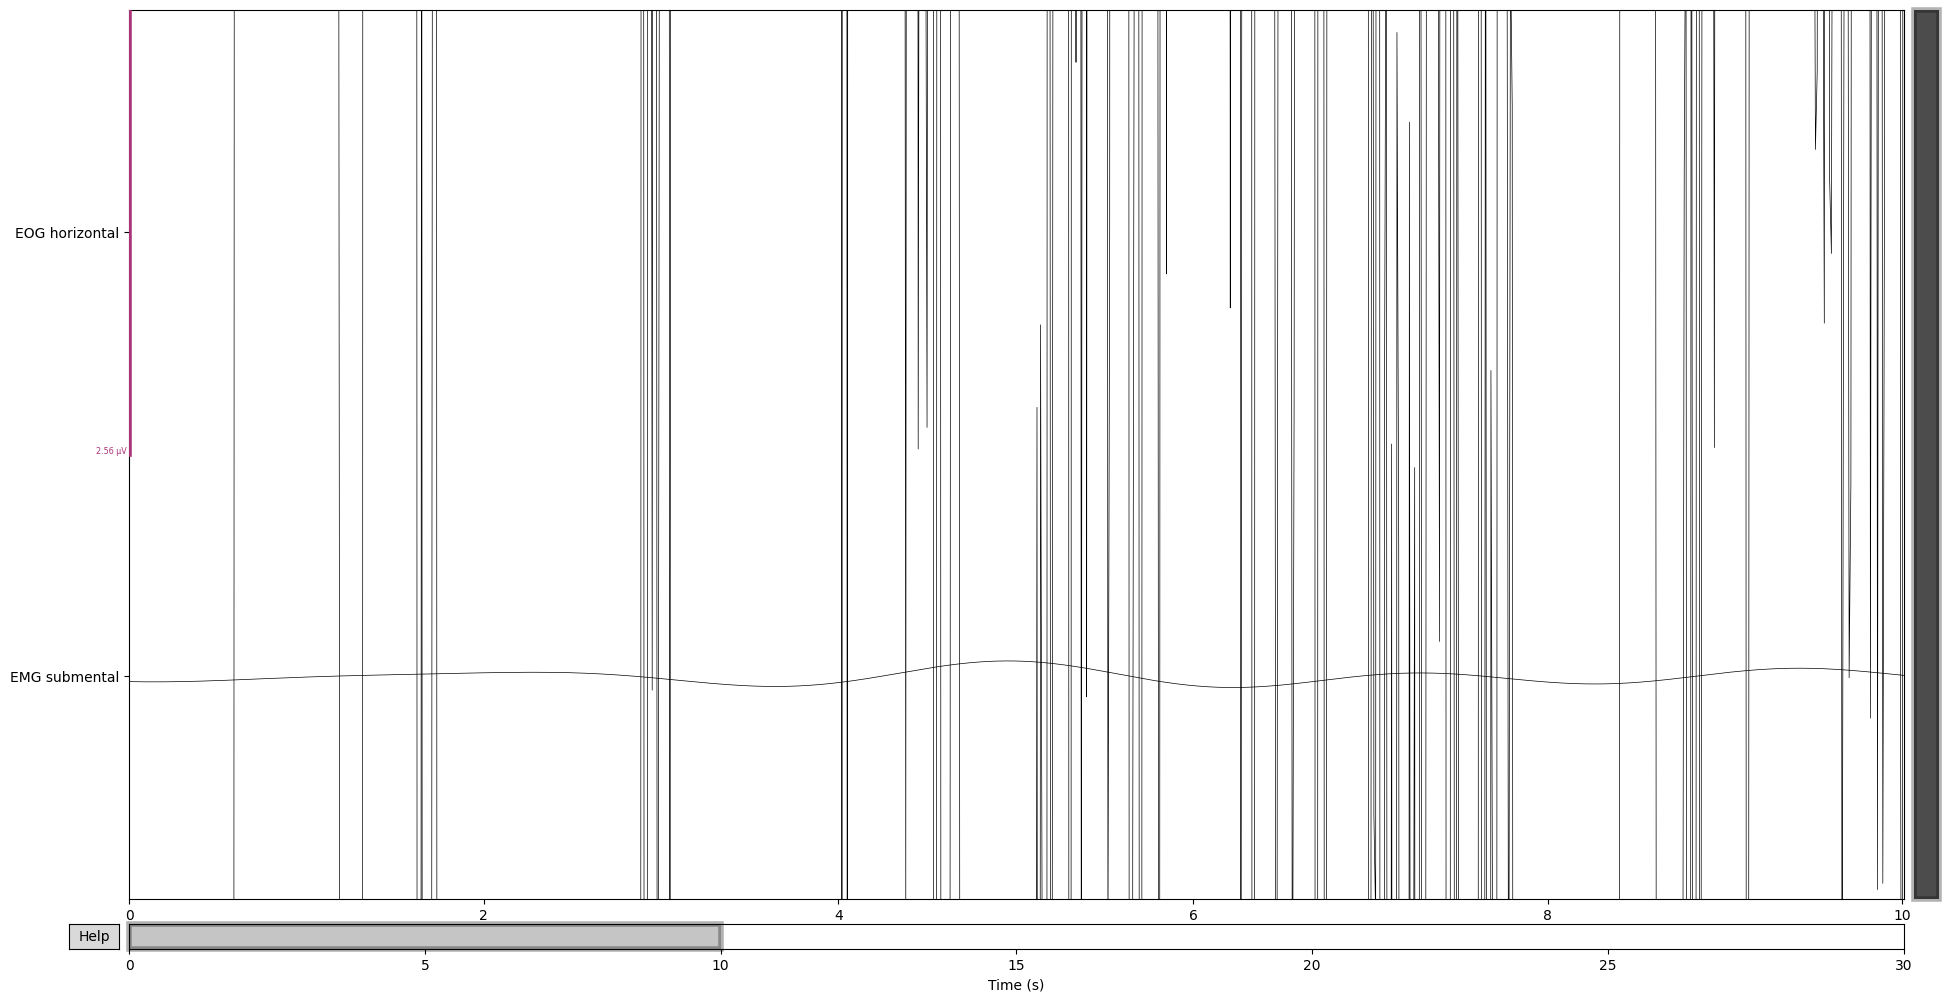

In [85]:
import mne

# Load the PSG file and plot
psg_file = "data/SC4001E0-PSG.edf"  
raw = mne.io.read_raw_edf(psg_file, preload=True)
raw.pick_channels(['EOG horizontal', 'EMG submental'])
raw.filter(0.5, 30)
raw.set_montage("standard_1020", on_missing="ignore")
start_time = 60  
end_time = 90    
raw_crop = raw.copy().crop(tmin=start_time, tmax=end_time)
raw_crop.plot(scalings='auto', title="EEG Epoch (60–90s) from SC4001E0")

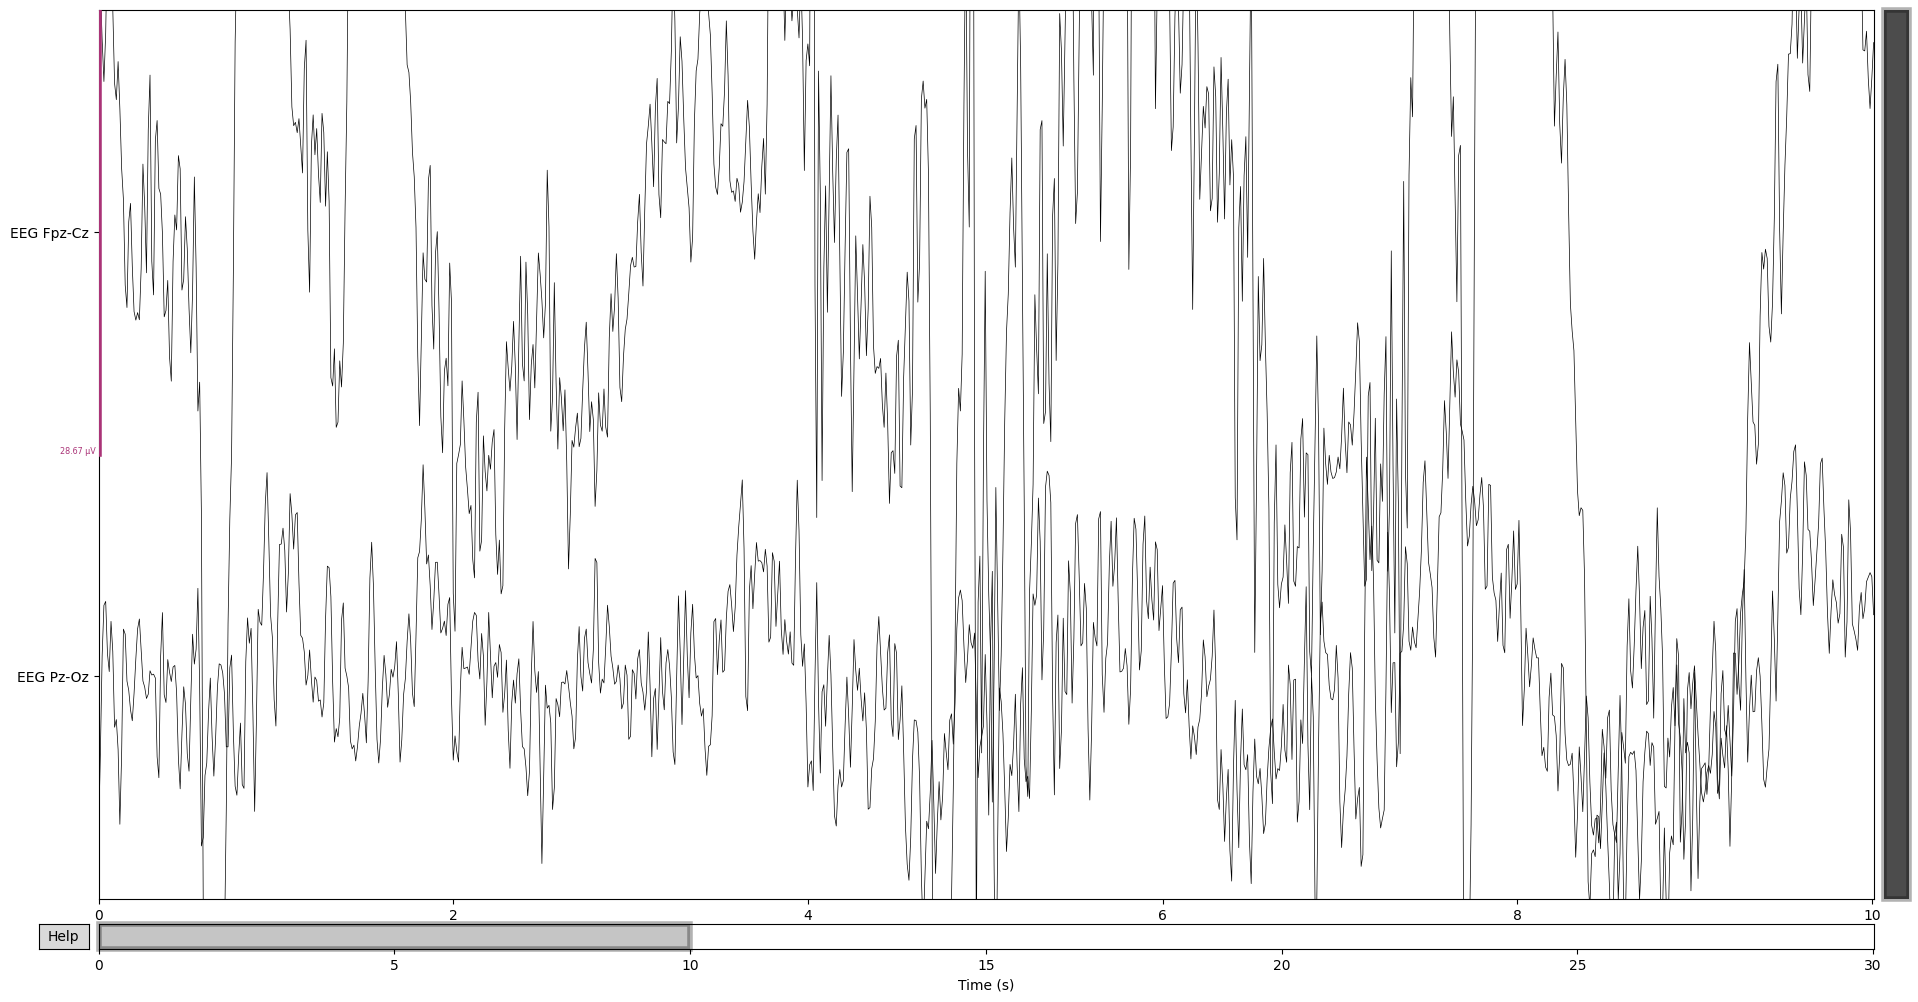

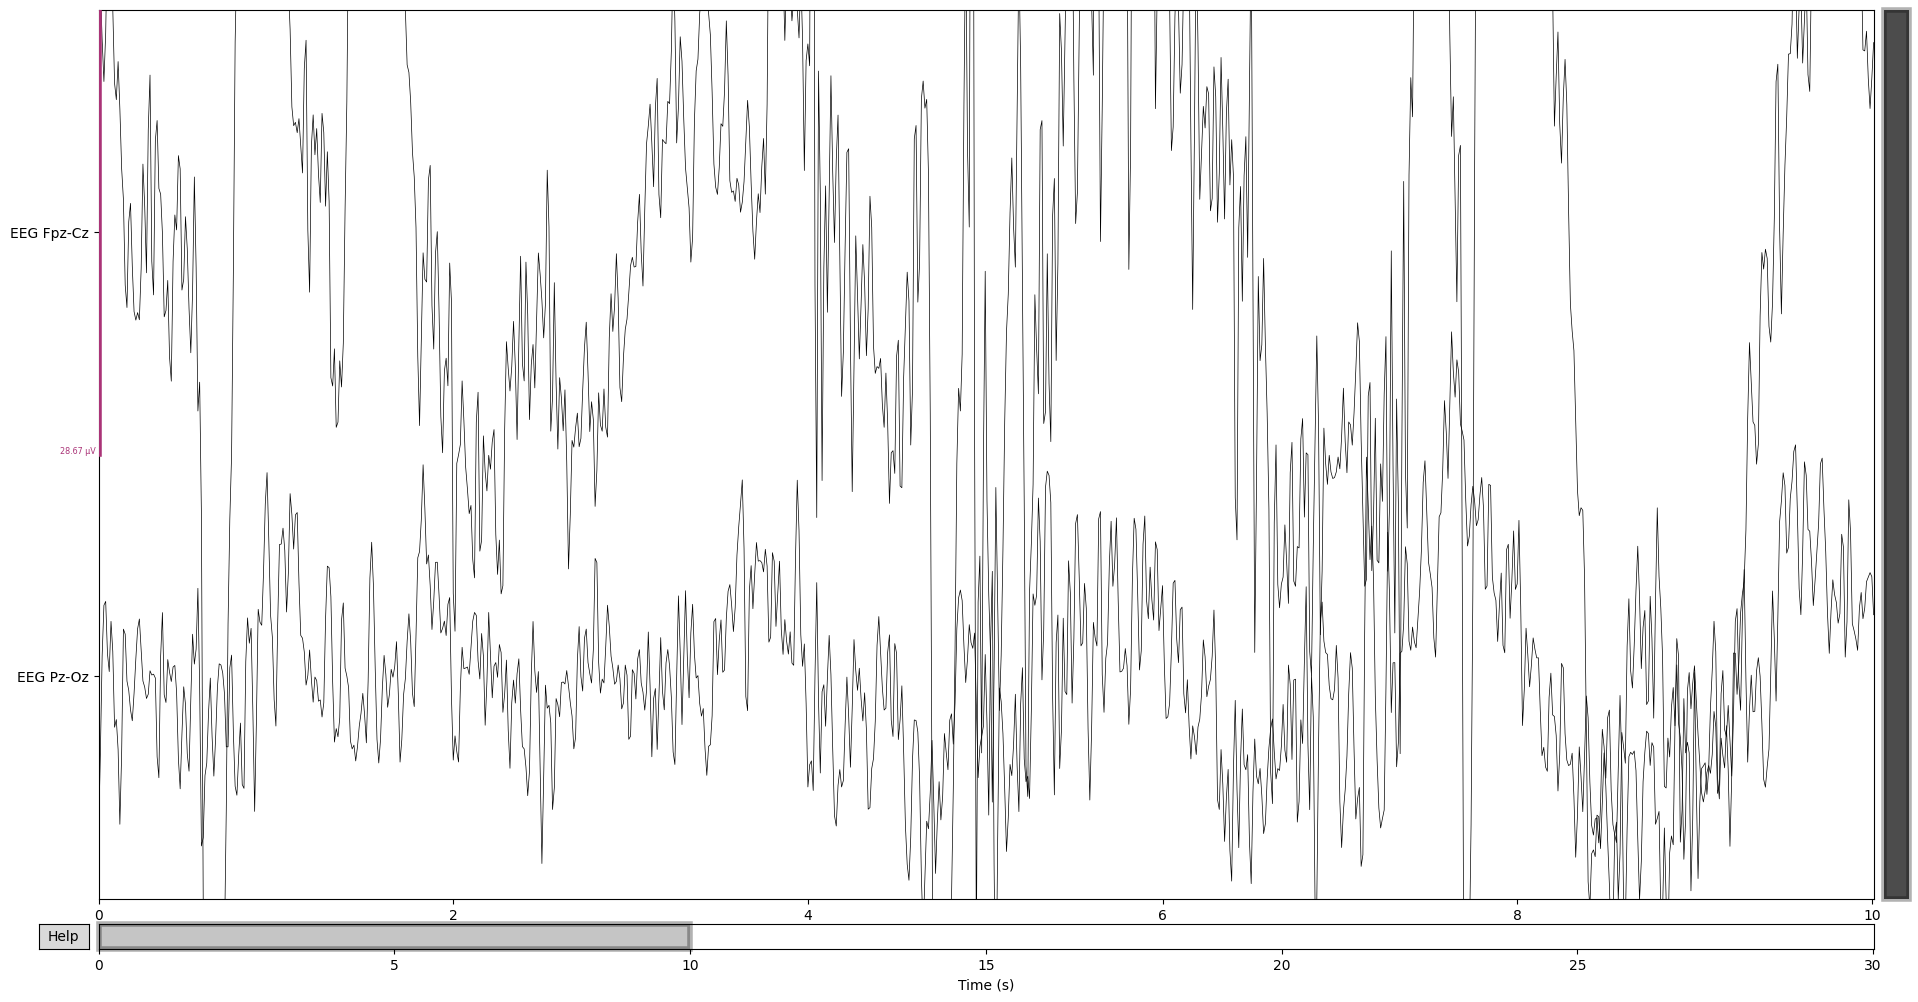

In [86]:
# Load the PSG file and plot
raw = mne.io.read_raw_edf(psg_file, preload=True)
raw.pick_channels(['EEG Fpz-Cz', 'EEG Pz-Oz'])
raw.filter(0.5, 30)
raw.set_montage("standard_1020", on_missing="ignore")
start_time = 60  
end_time = 90    
raw_crop = raw.copy().crop(tmin=start_time, tmax=end_time)
raw_crop.plot(scalings='auto', title="EEG Epoch (60–90s) from SC4001E0")

In [87]:
# Hypnogram file (annotation EDF)
annotations = mne.read_annotations("data\SC4001EC-Hypnogram.edf")
print(annotations[:5]) 

<Annotations | 5 segments: Sleep stage 1 (1), Sleep stage 2 (2), Sleep ...>


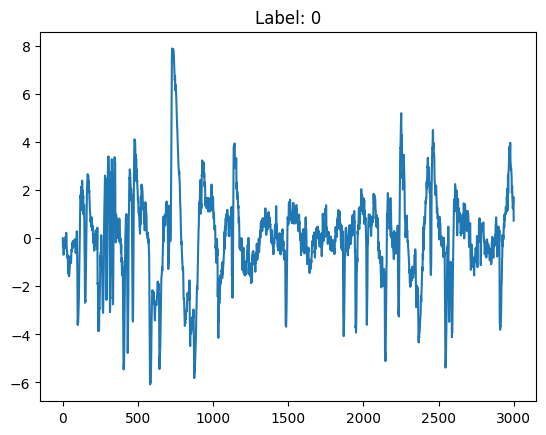

In [88]:
import matplotlib.pyplot as plt
plt.plot(X[0][0])  
plt.title(f"Label: {y[0]}")
plt.show()


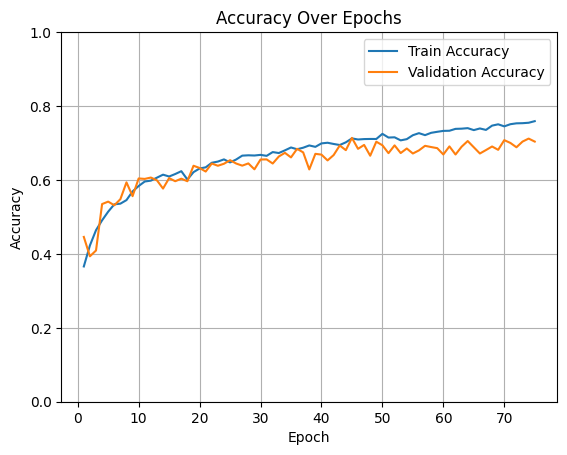

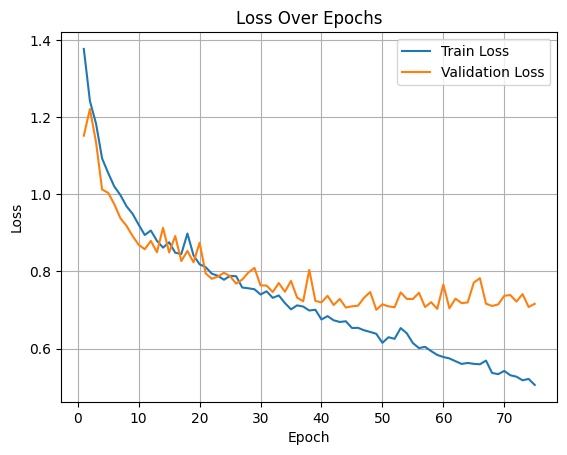

In [60]:
# Plot training curves
plot_curve("plots/training_metrics")

Using device: NVIDIA GeForce RTX 4060
Epoch  1/75: Train Loss: 1.3833, Train Acc: 0.3859 | Val Loss: 1.2194, Val Acc: 0.5414
Epoch  2/75: Train Loss: 1.1544, Train Acc: 0.4825 | Val Loss: 1.0723, Val Acc: 0.4742
Epoch  3/75: Train Loss: 1.1208, Train Acc: 0.4838 | Val Loss: 1.0534, Val Acc: 0.5294
Epoch  4/75: Train Loss: 1.0565, Train Acc: 0.5083 | Val Loss: 1.0434, Val Acc: 0.4782
Epoch  5/75: Train Loss: 1.0662, Train Acc: 0.5040 | Val Loss: 1.0304, Val Acc: 0.5372
Epoch  6/75: Train Loss: 1.0417, Train Acc: 0.5260 | Val Loss: 0.9716, Val Acc: 0.5297
Epoch  7/75: Train Loss: 1.0402, Train Acc: 0.5281 | Val Loss: 1.0110, Val Acc: 0.5929
Epoch  8/75: Train Loss: 1.0051, Train Acc: 0.5555 | Val Loss: 0.9354, Val Acc: 0.5372
Epoch  9/75: Train Loss: 1.0489, Train Acc: 0.5134 | Val Loss: 1.0108, Val Acc: 0.5279
Epoch 10/75: Train Loss: 0.9854, Train Acc: 0.5347 | Val Loss: 0.9309, Val Acc: 0.5487
Epoch 11/75: Train Loss: 0.9518, Train Acc: 0.5549 | Val Loss: 0.9104, Val Acc: 0.5453
Epoch

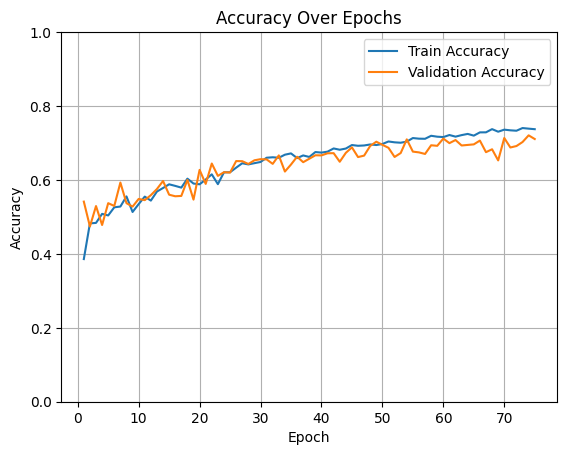

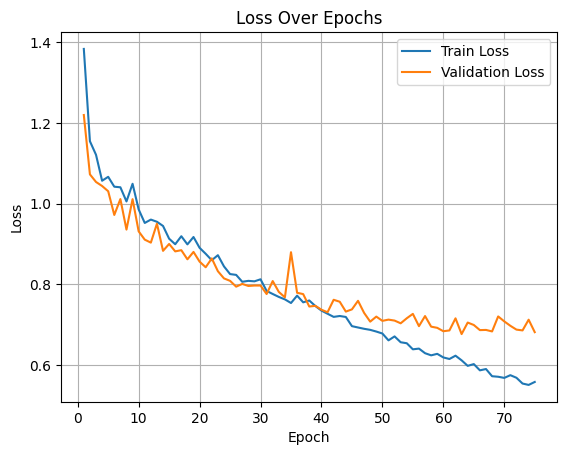

In [90]:
model = EEG_Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loss, train_err, val_loss, val_err = train_CNN(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    weight=class_weights.to(device),
    batch_size=32,
    learning_rate=0.0001,
    num_epochs=75,
    plot_path="plots/training_metrics"
)

# Plot training curves
plot_curve("plots/training_metrics")

In [91]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Final evaluation on test set
test_err, test_loss, test_f1, test_report, test_conf = evaluate(model, test_loader, criterion, device)

print(f"Test Accuracy {1-test_err:.4f}, Test Loss: {test_loss:.4f}")
print(f"Test F1 (macro): {test_f1:.4f}")

# Map class IDs to sleep stage names
sleep_stages = ['Wake', 'N1', 'N2', 'N3', 'REM']

# Create DataFrame from classification report
df = pd.DataFrame(test_report).T  
df = df.loc[[str(i) for i in range(5)]] 
df.index = sleep_stages 
df = df[["precision", "recall", "f1-score", "support"]]  

# Round for display
df = df.round(4)

# Print the table 
print("\nClassification Report:")
print(df)

# Confusion matrix
print(f"\nConfusion Matrix:")
print(test_conf)

Test Accuracy 0.7321, Test Loss: 0.6645
Test F1 (macro): 0.7221

Classification Report:
      precision  recall  f1-score  support
Wake     0.7598  0.7380    0.7488    523.0
N1       0.7165  0.6450    0.6789    921.0
N2       0.7226  0.7048    0.7136    935.0
N3       0.8169  0.8883    0.8511    698.0
REM      0.5498  0.7066    0.6184    242.0

Confusion Matrix:
[[386 120   2   3  12]
 [115 594 143  11  58]
 [  5  79 659 123  69]
 [  0   1  76 620   1]
 [  2  35  32   2 171]]


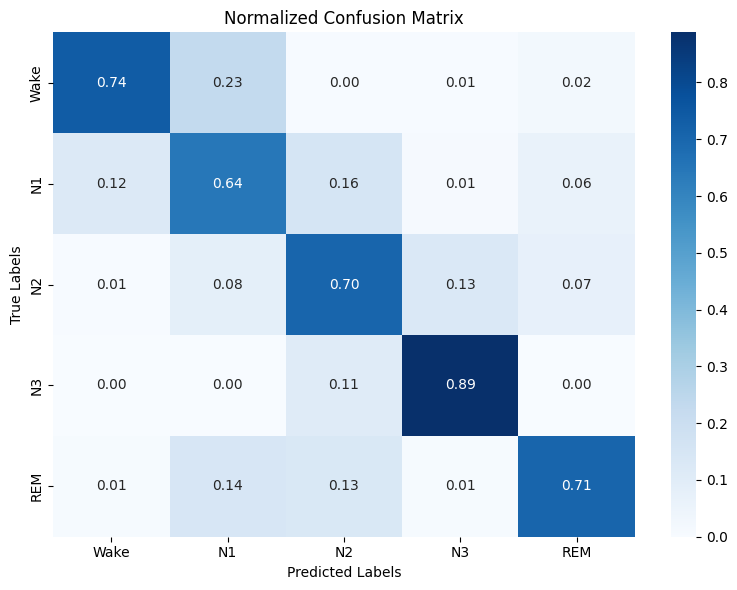

In [92]:
# Confusion matrix plot
labels = ['Wake', 'N1', 'N2', 'N3', 'REM']

conf_norm = test_conf.astype("float") / test_conf.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


In [93]:
# Preprocess data (four unseen subjects)
if os.path.exists("data2/X.npy") and os.path.exists("data2/y.npy"):
    X_unseen = np.load("data2/X.npy")
    y_unseen = np.load("data2/y.npy")
else:
    X_unseen, y_unseen = preprocess_data("C:/Users/namgy/OneDrive/Desktop/sleep-stage-visualizer/data2")
    np.save("data2/X.npy", X_unseen)
    np.save("data2/y.npy", y_unseen)

# Create test loader with unseen subjects
X_tensor = torch.tensor(X_unseen).float()
y_tensor = torch.tensor(y_unseen).long()
test_dataset2 = TensorDataset(X_tensor, y_tensor)
test_loader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False)
print("Number of test samples:", len(test_loader2.dataset))

# Evaluate
criterion = torch.nn.CrossEntropyLoss()
error, avg_loss, f1_macro, test_report, conf_mat = evaluate(model, test_loader2, criterion, device)

# Show results
print(f"Test accuracy: {1-error:.4f}, Test loss: {avg_loss:.4f}")
print("\nPer-class F1 Scores (on unseen set):")
for cls_id in range(5): 
    f1 = test_report[str(cls_id)]['f1-score']
    print(f"  Class {cls_id}: F1 = {f1:.4f}")

print("\nConfusion Matrix (on unseen set):")
print(conf_mat)

Number of test samples: 498
Test accuracy: 0.7470, Test loss: 0.5995

Per-class F1 Scores (on unseen set):
  Class 0: F1 = 0.7845
  Class 1: F1 = 0.6773
  Class 2: F1 = 0.6950
  Class 3: F1 = 0.8430
  Class 4: F1 = 0.7805

Confusion Matrix (on unseen set):
[[71 16  1  0  0]
 [20 85 19  0  9]
 [ 2 15 90  7  8]
 [ 0  2 26 94  0]
 [ 0  0  1  0 32]]


In [94]:
# Save model weights 
torch.save(model.state_dict(), "model_weights.pth")
print("Model saved!")

Model saved!
